In [27]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
import math
import feather #Instalacion:  conda install -c conda-forge feather-format
import geocoder # conda install -c conda-forge geocoder
import operator

In [8]:
df = pd.read_csv("Data/properatti.csv", sep = ",")

In [33]:
# borrar columnas innecesarias
# https://gitlab.com/dsdh/properatti/issues/14
to_drop = [
            'operation', #todas las operaciones son sell
            'country_name', # todas son argentina
            'expenses', # no aporta
            'properati_url', # no aporta
            'image_thumbnail' # no aporta
        ] #listar columnas no utilizadas
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(2)

In [41]:
# verifico index unique  y coluna Unnamed: 0
# https://gitlab.com/dsdh/properatti/issues/15
df.index.is_unique
df['Unnamed: 0'].is_unique
#'Unnamed: 0', #esta columna es igual al index
df.rename(index=str, columns={"Unnamed: 0": "indice"}, inplace=True) # reemplazo por indice porque la voy a utilizar para operaciones agregadas
df.sample(2)

,indice,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,...,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,description,title
83365,83365,apartment,Córdoba,|Argentina|Córdoba|Córdoba|,Córdoba,3860259.0,NaN,NaN,NaN,2218000.0,...,2194862.69,124393.59,NaN,78.0,NaN,28435.897436,NaN,NaN,2 DORMITORIOS COCINA SEPARADA EXTERNO BALCON T...,Departamento - Jardin
1183,1183,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Bs.As. G.B.A. Zona Norte,NaN,"-34.3961118699,-58.6476501255",-34.396112,-58.64765,185000.0,...,3264232.50,185000.00,58.0,52.0,3189.655172,3557.692308,NaN,2.0,Departamento de 2 ambientes en el 4º piso del ...,WYNDHAM - CONDOMINIOS | Departamento en la Ba...


In [103]:
# guardo resultados en feather (Instalacion:  conda install -c conda-forge feather-format)
#feather.write_dataframe(df, 'Data/intermedio.feather')
#recargo resultados
df = feather.read_dataframe('Data/intermedio.feather')
df.sample(1)

,indice,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,...,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,description,title
116727,116727,apartment,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,3430813.0,None,NaN,NaN,281534.0,...,4967526.66,281534.0,80.0,72.0,3519.175,3910.194444,NaN,NaN,Unidad de 3 ambientes en el 3er piso con vista...,Departamento - Martinez


In [216]:
# Data wrangling de place_with_parent_names
# https://gitlab.com/dsdh/properatti/issues/9

df.place_with_parent_names = df.place_with_parent_names.map(str.lower) #llevo a minusculas para evitar duplicados
grouped_places = df.groupby(['place_with_parent_names']) #agrupo por place_with_parent_names
dictio_places = grouped_places.groups.keys() #genero diccionario de places
cantidad_places = len(dictio_places) #cuento la cantidad de places distintos
print("Cantidad de place_with_parent_names distintos: ",cantidad_places)

count_x_places = grouped_places.agg({"indice": "count"}) #agrupo y cuento
count_x_places = count_x_places.rename(index=str, columns={"indice": "cantidad"}) #renombro la columna por cantidad
count_x_places = count_x_places.sort_values(by=['cantidad'], ascending=False) #ordeno por cantidad descendente

len(count_x_places.query("cantidad > 50")) # places con mas de <n> registros. Solo consulta


list_places = [sub_places.split('|') for sub_places in count_x_places.index]

df_places = pd.DataFrame(list_places, 
                         index = count_x_places.index, 
                         columns =['none1','pais','provincia','partido','localidad','barrio','none2']) 

df_places = df_places.drop(['none1', 'none2'], axis=1) # elimino none1 y none2
df_places = df_places.drop(['pais'], axis=1) # elimino pais ya que todos son argentina
df_places[df_places.barrio.notnull()] # el unico que tiene barrios es tigre-nordelta
df_places = df_places.drop(['barrio'], axis=1) # elimino barrio tambien

# Para cada columna busco vacios y asigno None
for column_name in df_places.columns:
    df_places[column_name][df_places[column_name].apply(lambda column_name: True if re.search('^\s*$', str(column_name)) else False)]=None

df_places = df_places.sort_values(by=['provincia','partido','localidad']) #ordeno

# creo df de provincias partidos y localidades
df_provincias = pd.DataFrame(df_places.provincia.unique(),columns=['nombre'])
df_partidos = pd.DataFrame(df_places.partido.unique(),columns=['nombre'])
df_localidades = pd.DataFrame(df_places.localidad.unique(),columns=['nombre'])

def buscar_reemplazar_place_column(row,column_name,df_base):
    if row[column_name]:
        idx = df_base.index[df_base.nombre == row[column_name]]
        return int(idx.data[0])
    
df_places.provincia =  df_places.apply(buscar_reemplazar_place_column,args=('provincia',df_provincias),axis=1)
df_places.partido =  df_places.apply(buscar_reemplazar_place_column,args=('partido',df_partidos),axis=1)
df_places.localidad =  df_places.apply(buscar_reemplazar_place_column,args=('localidad',df_localidades),axis=1)
df_places.sample(5)

Cantidad de place_with_parent_names distintos:  1164


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Int64Index.data is deprecated and will be removed in a future version


,provincia,partido,localidad
place_with_parent_names,,,
|argentina|tucumán|lules|,27,533.0,NaN
|argentina|bs.as. g.b.a. zona norte|escobar|los robles de maschwitz|,0,0.0,34.0
|argentina|bs.as. g.b.a. zona oeste|tres de febrero|ciudadela|,1,19.0,312.0
|argentina|córdoba|villa dolores|,10,309.0,NaN
|argentina|bs.as. g.b.a. zona norte|vicente lópez|la lucila|,0,9.0,241.0


In [240]:
# agrega la relacion para las columnas que se vayan pasando respecto al dataframe de provincias, localidades y partidos
def agregar_columna_place(row,column_name,test):
    if (row.place_with_parent_names):
        return df_places.loc[row.place_with_parent_names][column_name]
    
provincias = df.apply(agregar_columna_place,args=('provincia','random'),axis=1)
df['provincia'] = pd.Series(provincias, index=df.index)
partidos = df.apply(agregar_columna_place,args=('partido','random'),axis=1)
df['partido'] = pd.Series(partidos, index=df.index)
localidades = df.apply(agregar_columna_place,args=('localidad','random'),axis=1)
df['localidad'] = pd.Series(localidades, index=df.index)
df.sample(1)

,indice,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,description,title,provincia,partido,localidad
68769,68769,house,Canning,|argentina|bs.as. g.b.a. zona sur|ezeiza|canning|,Bs.As. G.B.A. Zona Sur,3435719.0,None,NaN,NaN,300000.0,...,NaN,375.000000,NaN,NaN,NaN,CHALET EN CANNING SOBRE 2 LOTES DE 10 X 40 C/...,Casa tipo chalet en Canning,2.0,25.0,369.0
103035,103035,house,Nordelta,|argentina|bs.as. g.b.a. zona norte|tigre|nord...,Bs.As. G.B.A. Zona Norte,NaN,None,NaN,NaN,980000.0,...,350.0,2390.243902,2800.0,NaN,NaN,"Casa en venta en barrio exclusivo de Nordelta,...",Casa - Venta- 6 ambientes - Las Caletas,0.0,8.0,220.0
71431,71431,apartment,Villa del Parque,|argentina|capital federal|villa del parque|,Capital Federal,3427455.0,"-34.5969204107,-58.4966809846",-34.59692,-58.496681,78000.0,...,30.0,NaN,2600.0,NaN,NaN,"Excelente dpto, monoambiente a estrenar, en ex...",Excelente monoambiente al frente a estrenar c/...,5.0,173.0,NaN


In [170]:
# Analisis del cambio de columnas realizado con place_with parent names
df.place_name = df.place_name[df.place_name.notnull()].map(str.lower)
df_place_name = df.place_name

df_place_name_not_in_part = df_place_name[~(df_place_name.isin(df_partidos.nombre))]
df_place_name_not_in_loc = df_place_name_not_in[~(df_place_name_not_in.isin(df_localidades.nombre))]
df_place_name_not_in_loc_prov = df_place_name_not_in_loc[~(df_place_name_not_in_loc.isin(df_provincias.nombre))]
df_place_name_not_in_loc_prov.unique()
#Puedo eliminar la columna place_name

array(['barrio el golf', 'barrio las glorietas', 'barrio los lagos',
       'enyoi', 'qbay yacht', 'barrio la alameda', 'islas del canal',
       'barrio los alisos', 'barrioportezuelo', 'barrio la isla',
       'barrio los tilos', 'barrio los sauces', 'barrio cabos del lago',
       'barrio los castores', 'barrio barrancas del lago',
       'barrio el yacht'], dtype=object)

In [171]:
# Reemplazo los valores que encuentro en place_name y que estan definidos en partidos
df.place_name = df.place_name[df.place_name.notnull()].map(str.lower)
def buscar_reemplazar_place_definidos(row,column_name,df_base): # funcion que buscar y reemplaza de la columna base (provincia, localidad, partido)
    a = df_base.nombre.str.contains(row[column_name], regex=False).any()
    if a:
        idx = df_base.index[df_base.nombre == row[column_name]]
        return int(idx.data[0])
    
df_place_name = df.place_name
# df_place_name_in_part = df_place_name[(df_place_name.isin(df_partidos.nombre))] #registros que estan en partidos
mask_in_partidos = (df_place_name.isin(df_partidos.nombre))
mask_not_column_partido = df.partido.isnull()

print("Partidos con null:",df.partido.isnull().sum())
df_reemplazar_part = df[mask_not_column_partido&mask_in_partidos].apply(buscar_reemplazar_place_definidos,args=('place_name',df_partidos),axis=1)
df.partido.update(df_reemplazar_part)
print("Partidos con null luego de procesar:",df.partido.isnull().sum())


Partidos con null: 4780


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  import sys


Partidos con null luego de procesar: 1904


In [172]:
# Reemplazo los valores que encuentro en place_name y que estan definidos en localidades

df_place_name = df.place_name
# df_place_name_in_part = df_place_name[(df_place_name.isin(df_localidades.nombre))] #registros que estan en localidades
mask_in_localidades = (df_place_name.isin(df_localidades.nombre))
mask_not_column_localidad = df.localidad.isnull()

print("Localidades con null:",df.localidad.isnull().sum())
df_reemplazar_loc = df[mask_not_column_localidad&mask_in_localidades].apply(buscar_reemplazar_place_definidos,args=('place_name',df_localidades),axis=1)
df.localidad.update(df_reemplazar_loc)
print("Localidades con null luego de procesar:",df.localidad.isnull().sum())

Localidades con null: 80803


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  import sys


Localidades con null luego de procesar: 68992


In [178]:
# borrar columnas que ya no se utilizaran
to_drop = [
            'place_name', # ya no se utilizara
            'place_with_parent_names', # se hizo el data wrangling
            'state_name' # esta completo en columna provincia
        ] #listar columnas no utilizadas
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(2)

,indice,property_type,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,description,title,provincia,partido,localidad
101408,101408,apartment,3860255.0,None,NaN,NaN,1980000.0,ARS,1959345.50,111045.68,...,NaN,NaN,NaN,NaN,NaN,"Departamento con Internet, Argentina, Córdoba,...",Departamento - Nueva Cordoba,10.0,234.0,NaN
5974,5974,apartment,NaN,"-34.433301,-58.586118",-34.433301,-58.586118,132300.0,USD,2334367.35,132300.00,...,62.0,NaN,2133.870968,704.0,3.0,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,NUEVO RIVERSIDE PRE-LANZAMIENTO,0.0,8.0,232.0


In [228]:
# 1. Completar el precio por metro cuadrado en dolares mediante el valor de precio por metro cuadrado cuando el currency es usd
# https://gitlab.com/dsdh/properatti/issues/5
#uniques = df.currency.unique()
#uniques
print("Cantidad de precios USD nulos 1: ",len(df[df.price_usd_per_m2.isnull()==True]))
# condicion dolar 'USD'
usd = 'USD'; cond_currency_usd = (df.currency == usd)
# condicion dolar 'USD'
cond_notusdprice_m2 = df.price_usd_per_m2.isnull()
# condicion price_per_m2 definido
cond_price_m2 = df.price_per_m2.notnull()
#mascara
mask_price_1 = cond_currency_usd & cond_notusdprice_m2 & cond_price_m2
df_price = df[mask_price_1 == True]

print("----Cantidad a reemplazar: ",len(df_price))
df.price_usd_per_m2.update(df_price.price_per_m2)
print("Result ==> Cantidad de precios USD nulos luego: ",len(df[df.price_usd_per_m2.isnull()==True]))

#ejemplo
df.iloc[68]

Cantidad de precios USD nulos 1:  52603
----Cantidad a reemplazar:  21437
Result ==> Cantidad de precios USD nulos luego:  31166


indice                                                                       68
property_type                                                         apartment
geonames_id                                                         3.43086e+06
lat-lon                                                  -38.034794,-57.5416872
lat                                                                    -38.0348
lon                                                                    -57.5417
price                                                                    235000
currency                                                                    USD
price_aprox_local_currency                                          4.14646e+06
price_aprox_usd                                                          235000
surface_total_in_m2                                                         NaN
surface_covered_in_m2                                                        72
price_usd_per_m2                        

In [229]:
# 2. Calcular precio por metro cuadrado a partir de superficie
# https://gitlab.com/dsdh/properatti/issues/2
print("Cantidad de precios USD nulos 2: ",len(df[df.price_usd_per_m2.isnull()==True]))
# condicion en mask1
mask1 = (df.price_usd_per_m2.isnull())& (df.surface_covered_in_m2.notnull()) & (df.price_aprox_usd.notnull())
df1 = df[mask1]

print("----Cantidad a reemplazar: ",len(df1))
# Tal vez deberia hacerse la superficie total no la cubierta
x = df1.price_aprox_usd/df1.surface_covered_in_m2
df.price_usd_per_m2.update(x)
print("Result ==> Cantidad de precios USD nulos luego: ",len(df[df.price_usd_per_m2.isnull()==True]))

#ejemplo
df.iloc[154]

Cantidad de precios USD nulos 2:  31166
----Cantidad a reemplazar:  2871
Result ==> Cantidad de precios USD nulos luego:  28295


indice                                                                      154
property_type                                                         apartment
geonames_id                                                         3.83628e+06
lat-lon                                                   -31.622319,-60.705482
lat                                                                    -31.6223
lon                                                                    -60.7055
price                                                                   1.2e+06
currency                                                                    ARS
price_aprox_local_currency                                          1.18748e+06
price_aprox_usd                                                         67300.4
surface_total_in_m2                                                         NaN
surface_covered_in_m2                                                        40
price_usd_per_m2                        

In [12]:
#7: Evaluamos si los tres tipos de propidad que existen son "house", "apartment" y "PH".
casas = df.loc[:,"property_type"] == "house"
print("Cantidad de casas: ",casas.sum())

apartamentos = df.loc[:,"property_type"] == "apartment"
print("Cantidad de apartamentos: ",apartamentos.sum())

ph = df.loc[:,"property_type"] == "PH"
print("Cantidad de ph: ", ph.sum())

tipopropiedad = casas & apartamentos & ph
print("Propiedad sin tipo: ",tipopropiedad.sum())


Cantidad de casas:  40268
Cantidad de apartamentos:  71065
Cantidad de ph:  5751
Propiedad sin tipo:  0


In [4]:
# obtener ambientes de description o title
# Agarrar el dataframe y hacer los cambios en distintos pipelines ej 1-buscar 2-limpiar 3-reemplazar
df_description = df[df.description.notnull()]
pattern_amb = re.compile("(.*) amb")

def replace_str_number(str_numb):
    numbers_dict = {'uno': 1,'dos': 2,'tres':3,'cuatro':4,'cinco':5,'seis':6,'siete':7,'ocho':8,'nueve':9}
    if str_numb in numbers_dict:
        return numbers_dict[str_numb]
    else:
        return np.nan

def get_ambientes(row):
#     pattern_amb = re.compile("(.*) amb")
    result = pattern_amb.search(row)
    try:
        str_aux = result.group(1)
        array_amb = str_aux.split()
        cant_amb = array_amb[-1]
        try:
            cant_amb = int(cant_amb)
            return cant_amb
        except:
            return replace_str_number(cant_amb);
    except:
        return np.nan

print("Nulos con ambientes obtenidos a partir de rooms: ",df.rooms.isnull().sum())
#completo ambientes a partir de rooms (ambientes = rooms+1)
ambientes_from_roms = df[df.rooms >= 1 & df.rooms.notnull()].rooms + 1
ambientes_from_desc = df_description.description.apply(get_ambientes)
df.rooms.update(ambientes_from_roms)
df.rooms.update(ambientes_from_desc)
print("Nulos luego de procesar: ",df.rooms.isnull().sum())

In [239]:
# repito el paso anterior: obtengo ambientes del titulo
df_title = df[df.title.notnull()&df.rooms.isnull()]

print("Nulos antes: ",df.rooms.isnull().sum())
ambientes_from_title = df_title.title.apply(get_ambientes)
df.rooms.update(ambientes_from_title)
print("Nulos luego de procesar: ",df.rooms.isnull().sum())

Nulos antes:  62410
Nulos luego de procesar:  60175


In [245]:
#renombro la columna rooms por ambientes
df.rename(index=str, columns={"rooms": "ambientes"},inplace=True)

,indice,property_type,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,ambientes,description,title,provincia,partido,localidad
86526,86526,house,3430310.0,None,NaN,NaN,370000.0,USD,6528465.0,370000.0,...,247.0,1497.975709,1497.975709,NaN,NaN,"HERMOSA CASA , desarrollada en 2 niveles. DE ...",Casa en Olivos-Golf,0.0,9.0,243.0


In [249]:
df.floor.isnull().sum()
# borrar columna floor, esta muy incompleta
to_drop = ['floor']
df.drop(columns=to_drop, inplace=True) #aplicar drop
df.sample(1)

,indice,property_type,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,ambientes,description,title,provincia,partido,localidad
36881,36881,house,3427500.0,None,NaN,NaN,590000.0,USD,10410255.0,590000.0,560.0,430.0,1053.571429,1372.093023,NaN,"Punta Chica, Libertador al rÃ­o. Sobre CUL de ...","Casa 560m² con 3 Plantas en Illia, Pres. 400, ...",0.0,5.0,167.0


In [5]:
# repito el paso de obtener ambientes con str lower
df_title = df[df.title.notnull()&df.ambientes.isnull()]
df_title.title.map(str.lower)

print("Nulos antes title: ",df.ambientes.isnull().sum())
ambientes_from_title = df_title.title.map(str.lower).apply(get_ambientes)
df.ambientes.update(ambientes_from_title)
print("Nulos luego de procesar title: ",df.ambientes.isnull().sum())

df_description = df[df.description.notnull()&df.ambientes.isnull()]
ambientes_from_desc = df_description.description.map(str.lower).apply(get_ambientes)
df.ambientes.update(ambientes_from_desc)
print("Nulos luego de procesar description: ",df.ambientes.isnull().sum())

Nulos antes title:  60175
Nulos luego de procesar title:  56626
Nulos luego de procesar description:  52484


In [31]:
# Funcionalidad para obtener metros 2
df_title = df[df.title.notnull()]
df_title.title = df_title.title.map(str.lower)
pattern_m2 = re.compile("(\d+\s*) m2")

def get_m2(row):
#     pattern_amb = re.compile("(.*) amb")
    result = pattern_m2.search(row)
    try:
        str_aux = result.group(1)
        array_m2 = str_aux.split()
        m2 = array_m2[-1]
        try:
            m2 = float(m2)
            return m2
        except:
            return np.nan;
    except:
        return np.nan

print("Nulos m2 total surface: ",df.surface_total_in_m2.isnull().sum())
m2_from_title = df_title.title.apply(get_m2)
m2_from_title[m2_from_title.notnull()]
df.surface_total_in_m2.update(m2_from_title)
print("Nulos luego de procesar: ",df.surface_total_in_m2.isnull().sum())

Nulos m2 total surface:  38873
Nulos luego de procesar:  38873


In [43]:
#buscamos regenerar 39.328 datos faltantes en superficie total en la tabla, rellenando con el promedio
#del barrio de cada propiedad.

print("Nulos en surface_total_in_m2 antes:",df.surface_total_in_m2.isnull().sum())
# creamos una proporción de metros cubiertos sobre metros totales
propcubierto = df.surface_covered_in_m2 / df.surface_total_in_m2
mask = propcubierto < 1
propcubierto_clean  = propcubierto[mask]

#relevamos algunos casos anómalos, donde la proporción da mayor a uno (inverosímil). Desestimamos estos 1106 registros para este procedimiento.
tempmask = propcubierto > 1
np.sum(tempmask)

#creamos una nueva variable sin esos datos anómalos
mask = propcubierto < 1
propcubierto_clean  = propcubierto[mask]

#hay dos casos anómalos donde superficie cubierta es cero, los reemplazamos por np.nan para evitar conflictos en el siguiente paso.
masksurface0 = (df.surface_covered_in_m2 == 0)
df.surface_covered_in_m2[masksurface0] = np.nan

#la agregamos al dataframe 
df['propcubierto']=propcubierto_clean

#agrupamos por provincia(partido) el porcentaje promedio de m2cubierto/m2total
avg_propcubiertobarrio = df.groupby('partido')["propcubierto"].mean().sort_values(ascending = False)

#cantidad de datos para calcular la proporcion 
avg_propcubiertobarriocount = df.groupby('partido')["propcubierto"].count().sort_values(ascending = False)

#condición de la regla 1
removerporcantidadmask = avg_propcubiertobarriocount > 30

#cantidad de datos existentes en tabla
datos_en_tabla = df.groupby('partido')['partido'].count().sort_values(ascending = False)

#divido los datos existentes sobre los datos totales y obtengo la relación para la regla DOS
proporcion = avg_propcubiertobarriocount / datos_en_tabla
proporcion.round(2).sort_values(ascending = True)

#condición de la regla 2
removerporproporcionmask = proporcion > 0.25

#genero máscara con ambas condiciones
proporcionmask2 = removerporcantidadmask & removerporproporcionmask
propvalidados = avg_propcubiertobarrio[proporcionmask2]

#iteramos por las propiedades que tienen el dato faltante de superficie total y les inputamos la proporción promedio
#del barrio al que pertenecen, usando como dato la superficie cubierta.
# SUPERFICIE TOTAL = (SUPERFICIE CUBIERTA / PROPORCION CUBIERTOTOTAL)
#if(propvalidados.index.contains(row.partido)):

surface_total_in_m2_clean = []
for index, row in df.iterrows():
    
    if pd.isnull(row.surface_total_in_m2):    
        if(propvalidados.index.contains(row.partido)):        
            #surface_total_in_m2_clean.append(row.surface_covered_in_m2 / avg_propcubiertobarrio[row.partido]) VERSION DE PAULA CORRE
            surface_total_in_m2_clean.append(row.surface_covered_in_m2 / propvalidados.loc[row.partido]) #VERSION CON PROPVALIDADOS NO CORRE
        else:
            surface_total_in_m2_clean.append(row.surface_total_in_m2)    
    else:
        surface_total_in_m2_clean.append(row.surface_total_in_m2)
df["surface_total_in_m2_nueva"] = surface_total_in_m2_clean
df["surface_total_in_m2_nueva"]

#dropeamos los casos NaN
surfacetotalnueva_condatos = df.surface_total_in_m2_nueva.dropna()

#y finalmente, los reemplazamos en la columna "surface_total_in_m2_nueva" original del DF
df.surface_total_in_m2.update(surfacetotalnueva_condatos)

print("Nulos en surface_total_in_m2 despues:",df.surface_total_in_m2.isnull().sum())

Nulos en surface_total_in_m2 antes: 38873


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Nulos en surface_total_in_m2 despues: 21181


In [35]:
# obtengo los geonames con el id para completar aquellos que tengan partido en null
mask_partido_null=df.partido.isnull()
mask_geoname_notnull=df.geonames_id.notnull()
df_geonames = df[mask_partido_null&mask_geoname_notnull].geonames_id
list_geonames = df_geonames.unique() #geonames uniques que voy a rellenar en columna localidades
s_geonames = pd.Series(index =list_geonames)

for idx,val in s_geonames.iteritems():
    geo_id = int(idx)
    g = geocoder.geonames(geo_id, method='details', key='dalonso')
    s_geonames[idx] = g.address

s_geonames
# Obtuve todas provincias -> No sirve para nada porque esta completo

3433955.0      Buenos Aires F.D.
3435907.0           Buenos Aires
3430657.0               Misiones
3838830.0              Rio Negro
3861244.0                 Chubut
3835868.0    Santiago del Estero
3862286.0              Catamarca
3849574.0               La Pampa
3834450.0       Tierra del Fuego
3853404.0                  Jujuy
3861887.0                  Chaco
dtype: object

In [54]:
# Obtener partido a partir de latitud y longitud: No sirve porque se requiere api key
mask_partido_null=df.partido.isnull()
mask_lat_notnull=df['lat-lon'].notnull()
df_latlon = df[mask_partido_null&mask_lat_notnull]['lat-lon']
list_latlon = df_latlon.unique()
s_latlon = pd.Series(index =list_latlon)
g = geocoder.google([-38.416097,-63.616672], method='reverse', key='GMAPS_API_KEY')

<[REQUEST_DENIED] Google - Reverse [empty]>

In [ ]:
df = feather.read_dataframe('Data/intermedio.feather')
df_provincias = feather.read_dataframe('Data/provincias.feather')
df_partidos = feather.read_dataframe('Data/partidos.feather')
df_localidades = feather.read_dataframe('Data/localidades.feather')

In [86]:
# Busco y reemplazo el df principal los property types. Genero nueva serie con property_types
list_property_types = df.property_type.unique() # obtengo los tipos
s_property_types = pd.Series(list_property_types) # genero serie

def search_replace_property_types(row):
    test = s_property_types.str.contains(row.property_type, regex=False).any()
    if test:
        idx = s_property_types[s_property_types == row.property_type].index.data[0] #busco index a reemplazar
        return int(idx)

df_replace_property_type = df.apply(search_replace_property_types,axis=1) #obtengo para cada row el index de la nueva tabla de tipos
df.property_type.update(df_replace_property_type)
df_property_types = pd.DataFrame(s_property_types) # genero dataframe para almacenar
df_property_types.rename(index=str, columns={0: "nombre"}, inplace=True)

In [215]:
# paso columnas a lowercase
df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [216]:
# nuevo dataframe con valores de condicion de la propiedad
s_condicion = pd.Series(['estrenar', 'emprendimiento', 'reciclado','antiguo'])
df_condicion = pd.DataFrame(s_condicion) # genero dataframe para almacenar
df_condicion.rename(index=str, columns={0: "nombre"}, inplace=True)
df_condicion

,nombre
0,estrenar
1,emprendimiento
2,reciclado
3,antiguo


In [217]:
# busco en descripcion y title las propiedades que contengan la condiciones anteriores
def contain_string(row,column_name,match_string):
    if row[column_name] is None:
        return False
    if operator.contains(row[column_name], match_string):
        return True
    else:
        return False

mask_estrenar_desc = df.apply(contain_string,args=('description','estrenar'),axis=1)
mask_estrenar_title = df.apply(contain_string,args=('title','estrenar'),axis=1)
mask_estrenar = ((mask_estrenar_desc)|(mask_estrenar_title))

df['condicion']= np.nan
df_update = pd.DataFrame(df.condicion)
df_update[mask_estrenar] = 0
df.condicion.update(df_update.condicion)
print("Cantidad de propiedades a estrenar: ",len(df[df.condicion == 0]))


Cantidad de propiedades a estrenar:  13086


In [218]:
mask_emprendimiento_desc = df.apply(contain_string,args=('description','emprendimiento'),axis=1)
mask_emprendimiento_title = df.apply(contain_string,args=('title','emprendimiento'),axis=1)
mask_emprendimiento = ((mask_emprendimiento_desc)|(mask_emprendimiento_title))

df_update = pd.DataFrame(df.condicion)
df_update[mask_emprendimiento&df.condicion.isnull()] = 1
df.condicion.update(df_update.condicion)
print("Cantidad de propiedades emprendimiento: ",len(df[df.condicion == 1]))

Cantidad de propiedades emprendimiento:  4454


In [219]:
mask_reciclado_desc = df.apply(contain_string,args=('description','reciclado'),axis=1)
mask_reciclado_title = df.apply(contain_string,args=('title','reciclado'),axis=1)
mask_reciclado = ((mask_reciclado_desc)|(mask_reciclado_title))

df_update = pd.DataFrame(df.condicion)
df_update[mask_reciclado&df.condicion.isnull()] = 2
df.condicion.update(df_update.condicion)
print("Cantidad de propiedades reciclado: ",len(df[df.condicion == 2]))

Cantidad de propiedades reciclado:  3765


In [220]:
mask_antiguo_desc = df.apply(contain_string,args=('description','antiguo'),axis=1)
mask_antiguo_title = df.apply(contain_string,args=('title','antiguo'),axis=1)
mask_antiguo = ((mask_antiguo_desc)|(mask_antiguo_title))

df_update = pd.DataFrame(df.condicion)
df_update[mask_antiguo&df.condicion.isnull()] = 3
df.condicion.update(df_update.condicion)
print("Cantidad de propiedades antiguas: ",len(df[df.condicion == 3]))

Cantidad de propiedades antiguas:  736


In [222]:
# nuevo es tambien a estrenar
mask_estrenar_desc = df.apply(contain_string,args=('description','nuevo'),axis=1)
mask_estrenar_title = df.apply(contain_string,args=('title','nuevo'),axis=1)
mask_estrenar = ((mask_estrenar_desc)|(mask_estrenar_title))

df['condicion']= np.nan
df_update = pd.DataFrame(df.condicion)
df_update[mask_estrenar] = 0
df.condicion.update(df_update.condicion)
print("Cantidad de propiedades a estrenar: ",len(df[df.condicion == 0]))

Cantidad de propiedades a estrenar:  8001


In [279]:
# <<CHECKPOINT>>: guardo resultados en feather (Instalacion:  conda install -c conda-forge feather-format)
# feather.write_dataframe(df, 'Data/intermedio.feather')
# feather.write_dataframe(df_provincias, 'Data/provincias.feather')
# feather.write_dataframe(df_partidos, 'Data/partidos.feather')
# feather.write_dataframe(df_localidades, 'Data/localidades.feather')
# feather.write_dataframe(df_property_types, 'Data/propertytypes.feather')
# feather.write_dataframe(df_condicion, 'Data/condicion.feather')

#recargo resultados
df = feather.read_dataframe('Data/intermedio.feather')
df_provincias = feather.read_dataframe('Data/provincias.feather')
df_partidos = feather.read_dataframe('Data/partidos.feather')
df_localidades = feather.read_dataframe('Data/localidades.feather')
df_property_types = feather.read_dataframe('Data/propertytypes.feather')
df_condicion = feather.read_dataframe('Data/condicion.feather')

df.sample(1)

ArrowIOError: Failed to open local file: Data/intermedio.feather , error: No such file or directory

In [270]:
# Nueva Funcion para obtener metros cuadrados
def find_number_before_pattern(string, text_pattern):
    if string is None:
        return np.nan
    if string.find(text_pattern) > -1:
        search1 = re.findall(r"(\d+)"+text_pattern, string)
        search2 = re.findall(r"(\d+) "+text_pattern, string)
        search = np.concatenate((search1, search2))
        if len(search) > 0: 
                return search[0]
    return np.nan

def get_m2_v2(row):
    return find_number_before_pattern(row.description,"m2")

print("Nulos m2 total surface antes:",df.surface_total_in_m2.isnull().sum())
df_update = df[df.surface_total_in_m2.isnull()].apply(get_m2_v2,axis=1)
df_update = df_update[df_update.notnull()]
df.surface_total_in_m2.update(df_update)
print("Nulos m2 total surface: ",df.surface_total_in_m2.isnull().sum())

Nulos m2 total surface antes: 21181
Nulos m2 total surface:  17715


In [278]:
#limpieza de columnas
to_drop = [
            'indice', 
            'currency', 
            'price_aprox_local_currency', 
            'propcubierto',
            'surface_total_in_m2_nueva',
            'geonames_id'
        ] #listar columnas no utilizadas
df.drop(columns=to_drop, inplace=True) #aplicar drop

In [276]:
# <<CHECKPOINT>>: guardo resultados en feather (Instalacion:  conda install -c conda-forge feather-format)
feather.write_dataframe(df, 'Data/intermedio.feather')
feather.write_dataframe(df_provincias, 'Data/provincias.feather')
feather.write_dataframe(df_partidos, 'Data/partidos.feather')
feather.write_dataframe(df_localidades, 'Data/localidades.feather')
feather.write_dataframe(df_property_types, 'Data/propertytypes.feather')
feather.write_dataframe(df_condicion, 'Data/condicion.feather')

#recargo resultados
# df = feather.read_dataframe('Data/intermedio.feather')
# df_provincias = feather.read_dataframe('Data/provincias.feather')
# df_partidos = feather.read_dataframe('Data/partidos.feather')
# df_localidades = feather.read_dataframe('Data/localidades.feather')
# df_property_types = feather.read_dataframe('Data/propertytypes.feather')
# df_condicion = feather.read_dataframe('Data/condicion.feather')

# df.sample(1)

ArrowIOError: Failed to open local file: Data/intermedio.feather , error: No such file or directory

In [62]:
#Comienza la funcion
def fillmean(set_df,groupby_array,aggregation_column):
#saco los null del df
    mask=set_df[aggregation_column].notnull()&set_df[aggregation_column]>0
    set_df=set_df[mask]
#Creo un groupby con las columnas que busco
    df_groupby=set_df.groupby(groupby_array)[aggregation_column].median()
#Convierte el grouby en un dataframe y resetea el index para hacer luego merge   
    df_groupby_df=pd.DataFrame(df_groupby)
    df_groupby_df=df_groupby.reset_index()
    
#Hago merge    
 
    df_merge = df.merge(df_groupby_df,how="left",on=groupby_array,suffixes=('', '_right'))
    #df_merge_apply=df.merge(df_groupby_df,how="left",on=[column1, column2,column3],suffixes=('', '_right'))

    aggregation_column_right=aggregation_column+"_right"
    
# cantidad de nulos antes de imputar
    null_before=sum(df_merge[aggregation_column].isnull())
    
    
#Remmplazo la columna del groupby en los null del df orginal
    for i,row in df_merge.iterrows():
        if np.isnan(df_merge.loc[i,aggregation_column]):
                    df_merge.loc[i,aggregation_column] = df_merge.loc[i, aggregation_column_right]

    #df[aggregation_column].apply(lambda x: x[aggregation_column] if x.isnan else x[aggregation_column_right])

# cantidad de nulos despues de imputar
    null_after=sum(df_merge[aggregation_column].isnull())           
    diff=null_before-null_after
    return print("Antes "+str(null_before)+", Despues "+str(null_after)+'\n'+"Se limpiaron "+str(diff)+" datos nulos")
#Termina funcion


In [59]:
groupby_array = ['provincia','partido','ambientes']
fillmean(df,groupby_array,'surface_total_in_m2')

Antes 21181, Despues 13202
Se limpiaron 7979 datos nulos


In [63]:
groupby_array = ['provincia','partido','property_type']
fillmean(df,groupby_array,'surface_total_in_m2')

Antes 21181, Despues 1187
Se limpiaron 19994 datos nulos


In [71]:
(df[df.provincia == 5].surface_total_in_m2.std()/df[df.provincia == 5].surface_total_in_m2.mean())*100
df[df.provincia == 5].surface_total_in_m2.describe()

count     31182.000000
mean        126.068712
std        1688.352395
min           0.000000
25%          43.000000
50%          63.000000
75%         112.000000
max      217375.120363
Name: surface_total_in_m2, dtype: float64

iqr: 1239.0506163126147
q1: 1236.5591397849462
q3: 2475.609756097561
median: 1800.0
Valor Left: -58.57592446892204  Cantidad de outliers: 0
Valor Right: 3658.575924468922  Cantidad de outliers: 6938


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0.0, 2390.0)

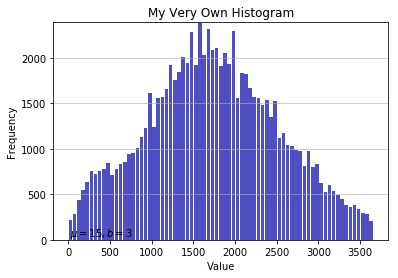

In [72]:
#q1_peso_usd_m2 = np.mean(price_usd_per_m2_arr) + 1*np.std(price_usd_per_m2_arr)
#q3_peso_usd_m2 = np.mean(price_usd_per_m2_arr) + 3*np.std(price_usd_per_m2_arr)

df_aux = df[df.price_usd_per_m2.notnull()] #elimino los nulos
q1_usd_m2, q3_usd_m2= np.percentile(df_aux.price_usd_per_m2,[25,75]) # obtengo q1 y q3
iqr_peso_usd_m2 = q3_usd_m2 - q1_usd_m2 #obtengo iqr
print("iqr:",iqr_peso_usd_m2)
print("q1:",q1_usd_m2)
print("q3:",q3_usd_m2)
median_price_usd_m2 = df_aux.price_usd_per_m2.median()
print("median:",median_price_usd_m2)


left_bound = median_price_usd_m2 -(1.5 * iqr_peso_usd_m2) 
right_bound = median_price_usd_m2 +(1.5 * iqr_peso_usd_m2) 

#df_aux.price_usd_per_m2[(np.abs(stats.zscore(df_aux.price_usd_per_m2)) < 3).all(axis=1)]

#print(left_bound,right_bound)
right_outliers = df_aux.price_usd_per_m2[np.abs(df_aux.price_usd_per_m2) > right_bound]
left_outliers = df_aux.price_usd_per_m2[np.abs(df_aux.price_usd_per_m2) < left_bound]
#left_outliers

print("Valor Left:",left_bound," Cantidad de outliers:",len(left_outliers))
print("Valor Right:",right_bound," Cantidad de outliers:",len(right_outliers))
#print(df_aux.price_usd_per_m2.describe())
df_aux = df_aux.drop(right_outliers.index)


right_outliers
#df_aux.iloc[57]

n, bins, patches = plt.hist(x=df_aux.price_usd_per_m2, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)



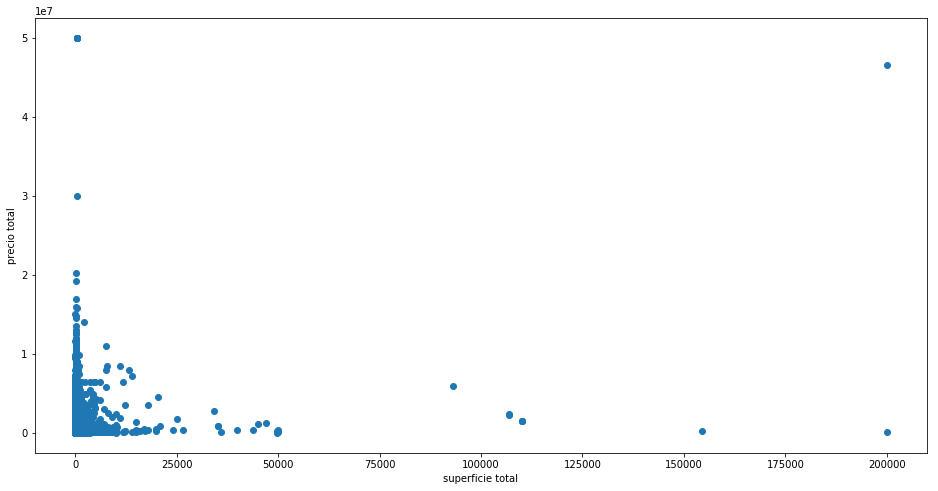

In [179]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df.surface_total_in_m2, df.price)
ax.set_xlabel('superficie total')
ax.set_ylabel('precio total')
plt.show()

In [22]:
# 1
# Relacion entre precio, cantidad de 
#         habitaciones y metros cuadrados cubiertos: Para saber en que punto tiene incidencia la cantidad de habitaciones

provincias = df.groupby("state_name").mean()
print(provincias)
barrios = df.groupby("place_name").mean()
print("cantidad de barrios:",len(barrios))

                                Unnamed: 0   geonames_id        lat  \
state_name                                                            
Bs.As. G.B.A. Zona Norte      57403.871557  3.432958e+06 -34.461298   
Bs.As. G.B.A. Zona Oeste      45997.683330  3.453478e+06 -34.644503   
Bs.As. G.B.A. Zona Sur        67393.747348  3.433987e+06 -34.803279   
Buenos Aires Costa Atlántica  47590.422646  3.455397e+06 -37.820371   
Buenos Aires Interior         47598.473592  3.618603e+06 -36.892797   
Capital Federal               61151.927095  3.528152e+06 -34.601818   
Catamarca                     35278.592593  3.845838e+06 -28.465495   
Chaco                         49302.105263  3.538969e+06 -27.452741   
Chubut                        83694.015444  3.852432e+06 -43.758762   
Corrientes                    86664.902230  3.433078e+06 -27.638352   
Córdoba                       74868.553733  3.855880e+06 -31.460336   
Entre Ríos                    53147.934959  3.461734e+06 -31.960400   
Formos

In [31]:
#Rellenar con el promedio la superficie total, agrupando por el promedio del barrio (posible peso 39.328)
#https://gitlab.com/dsdh/properatti/issues/4

#Reemplazo los casos donde la superficie cubierta es 0 por nan
mask_surface_cov0 = (df.surface_covered_in_m2 == 0)
df.surface_covered_in_m2[mask_surface_cov0] = np.nan

#Reemplazo los casos donde la superficie total es 0 por nan
mask_surface_tot0 = (df.surface_total_in_m2 == 0)
df.surface_total_in_m2[mask_surface_tot0] = np.nan

###################################################################
# creamos una proporción de metros cubiertos sobre metros totales
propcubierto = df.surface_covered_in_m2 / df.surface_total_in_m2

# obteno proporciones validas (si es mayor a 1 no es una proporcion)
mask_propcubierto_validas = propcubierto < 1
propcubierto_clean  = propcubierto[mask_propcubierto_validas]

#Agrego la columna propcubierto al dataframe principal
df.propcubierto=propcubierto_clean

#agrupamos por provincia(state_name) el porcentaje promedio de propcubierto (m2cubierto/m2total)
avg_propcubiertobarrio = df.groupby('state_name')["propcubierto"].mean().sort_values(ascending = False)
print(avg_propcubiertobarrio)

#antes de hacer el reemplazo, evaluamos si los datos que tenemos para aplicar el promedio cumple con un mínimo
#que lo haga fiable. Establecemos dos exigencias
# UNO - Que haya mas de 30 datos para obtener la proporción 
# DOS - Que la proporcion de datos disponibles sea mayor al 25%

#cantidad de datos para calcular la proporcion 
avg_propcubiertobarriocount = df.groupby('state_name')["propcubierto"].count().sort_values(ascending = False)

#mascara para obtener los que no tienen mas de 30 registros
mask_removerporcantidad = avg_propcubiertobarriocount > 30

#cantidad de datos existentes en tabla
mask_surface_notnull = df.surface_covered_in_m2.notnull()
df_recup_suf_tot = df[mask_surface_notnull].groupby('state_name')['state_name'].count().sort_values(ascending = False)

#divido los datos existentes sobre los datos totales y obtengo la relación para la regla DOS
proporcion = avg_propcubiertobarriocount / df_recup_suf_tot
proporcion.round(2).sort_values(ascending = True)

#condición de la regla 2
mask_removerporproporcion = proporcion > 0.25

#genero máscara con ambas condiciones
mask_proporcion = mask_removerporcantidad & mask_removerporproporcion
propvalidados = avg_propcubiertobarrio[mask_proporcion]
print ('estos son los que cumplen las dos condiciones y son fiables para el reemplazo', avg_propcubiertobarrio[mask_proporcion])

#iteramos por las propiedades que tienen el dato faltante de superficie total y les inputamos la proporción promedio
#del barrio al que pertenecen, usando como dato la superficie cubierta.
# SUPERFICIE TOTAL = (SUPERFICIE CUBIERTA / PROPORCION CUBIERTOTOTAL)

surface_total_in_m2_clean = []
for index, row in df.iterrows():
    
    
df["surface_total_in_m2_nueva"] = surface_total_in_m2_clean
df["surface_total_in_m2_nueva"]

def replace_sup_total(row):
    if pd.isnull(row.surface_total_in_m2):    
        if(propvalidados.index.contains(row.state_name)):        
            #surface_total_in_m2_clean.append(row.surface_covered_in_m2 / avg_propcubiertobarrio[row.state_name]) VERSION DE PAULA CORRE
            surface_total_in_m2_clean.append(row.surface_covered_in_m2 / propvalidados.loc[row.state_name]) #VERSION CON PROPVALIDADOS NO CORRE
        else:
            surface_total_in_m2_clean.append(row.surface_total_in_m2)    
    else:
        surface_total_in_m2_clean.append(row.surface_total_in_m2)

df.apply(replace_sup_total)




/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


state_name
Capital Federal                 0.833831
Santa Fe                        0.752178
Neuquén                         0.734619
Bs.As. G.B.A. Zona Sur          0.720536
Bs.As. G.B.A. Zona Norte        0.689866
Córdoba                         0.678031
Río Negro                       0.674219
Buenos Aires Costa Atlántica    0.669633
Tucumán                         0.658362
San Juan                        0.656184
Corrientes                      0.650579
Chaco                           0.635503
Bs.As. G.B.A. Zona Oeste        0.624836
Chubut                          0.611554
Santa Cruz                      0.609108
Tierra Del Fuego                0.565032
Entre Ríos                      0.545258
Salta                           0.530071
La Pampa                        0.520446
Buenos Aires Interior           0.500039
Mendoza                         0.496813
Misiones                        0.480108
Catamarca                       0.463895
San Luis                        0.428273
Santi

0           55.000000
1                 NaN
2           55.000000
3                 NaN
4           35.000000
5           53.000000
6          106.000000
7           45.000000
8           65.000000
9                 NaN
10        1514.000000
11                NaN
12          39.000000
13          50.000000
14          42.000000
15         164.000000
16         140.000000
17         176.000000
18         270.000000
19         104.000000
20         148.000000
21         118.000000
22         200.000000
23          48.000000
24         160.000000
25         160.000000
26         230.000000
27         425.000000
28         160.000000
29          43.000000
             ...     
121190     100.000000
121191      50.000000
121192      50.000000
121193     136.000000
121194      50.000000
121195      50.000000
121196      52.000000
121197      50.000000
121198      50.000000
121199      52.000000
121200      50.000000
121201      50.000000
121202      52.000000
121203      50.000000
121204    

In [35]:
#Rellenar con el promedio la superficie total, agrupando por el promedio del barrio (posible peso 39.328)
#https://gitlab.com/dsdh/properatti/issues/4

#Reemplazo los casos donde la superficie cubierta es 0 por nan
mask_surface_cov0 = (df.surface_covered_in_m2 == 0)
df.surface_covered_in_m2[mask_surface_cov0] = np.nan

#Reemplazo los casos donde la superficie total es 0 por nan
mask_surface_tot0 = (df.surface_total_in_m2 == 0)
df.surface_total_in_m2[mask_surface_tot0] = np.nan

###################################################################
# creamos una proporción de metros cubiertos sobre metros totales
propcubierto = df.surface_covered_in_m2 / df.surface_total_in_m2

# obteno proporciones validas (si es mayor a 1 no es una proporcion)
mask_propcubierto_validas = propcubierto < 1
propcubierto_clean  = propcubierto[mask_propcubierto_validas]

#Agrego la columna propcubierto al dataframe principal
df.propcubierto=propcubierto_clean

#agrupamos por provincia(state_name) el porcentaje promedio de propcubierto (m2cubierto/m2total)
avg_propcubiertobarrio = df.groupby('state_name')["propcubierto"].mean().sort_values(ascending = False)
print(avg_propcubiertobarrio)

#antes de hacer el reemplazo, evaluamos si los datos que tenemos para aplicar el promedio cumple con un mínimo
#que lo haga fiable. Establecemos dos exigencias
# UNO - Que haya mas de 30 datos para obtener la proporción 
# DOS - Que la proporcion de datos disponibles sea mayor al 25%

#cantidad de datos para calcular la proporcion 
avg_propcubiertobarriocount = df.groupby('state_name')["propcubierto"].count().sort_values(ascending = False)

#mascara para obtener los que no tienen mas de 30 registros
mask_removerporcantidad = avg_propcubiertobarriocount > 30

#cantidad de datos existentes en tabla
mask_surface_notnull = df.surface_covered_in_m2.notnull()
df_recup_suf_tot = df[mask_surface_notnull].groupby('state_name')['state_name'].count().sort_values(ascending = False)

#divido los datos existentes sobre los datos totales y obtengo la relación para la regla DOS
proporcion = avg_propcubiertobarriocount / df_recup_suf_tot
proporcion.round(2).sort_values(ascending = True)

#condición de la regla 2
mask_removerporproporcion = proporcion > 0.25

#genero máscara con ambas condiciones
mask_proporcion = mask_removerporcantidad & mask_removerporproporcion
propvalidados = avg_propcubiertobarrio[mask_proporcion]
print ('estos son los que cumplen las dos condiciones y son fiables para el reemplazo', avg_propcubiertobarrio[mask_proporcion])

#iteramos por las propiedades que tienen el dato faltante de superficie total y les inputamos la proporción promedio
#del barrio al que pertenecen, usando como dato la superficie cubierta.
# SUPERFICIE TOTAL = (SUPERFICIE CUBIERTA / PROPORCION CUBIERTOTOTAL)

# TODO: Mejorar con apply
surface_total_in_m2_clean = []
for index, row in df.iterrows():
    if pd.isnull(row.surface_total_in_m2):    
        if(propvalidados.index.contains(row.state_name)):        
            #surface_total_in_m2_clean.append(row.surface_covered_in_m2 / avg_propcubiertobarrio[row.state_name]) VERSION DE PAULA CORRE
            surface_total_in_m2_clean.append(row.surface_covered_in_m2 / propvalidados.loc[row.state_name]) #VERSION CON PROPVALIDADOS NO CORRE
        else:
            surface_total_in_m2_clean.append(row.surface_total_in_m2)    
    else:
        surface_total_in_m2_clean.append(row.surface_total_in_m2)

df["surface_total_in_m2_nueva"] = surface_total_in_m2_clean

#dropeamos los casos NaN
surfacetotalnueva_notnull = df.surface_total_in_m2_nueva.dropna()

#y finalmente, los reemplazamos en la columna "surface_total_in_m2_nueva" original del DF
df.surface_total_in_m2.update(surfacetotalnueva_notnull)


#df[['surface_total_in_m2', 'surface_total_in_m2_nueva']]
#verifico si son iguales, donde no coinciden levanta los casos nan unicamente pero en relaidad son iguales
#maskcheck = df.surface_total_in_m2 != df.surface_total_in_m2_nueva
#asdasd = df[maskcheck]
#asdasd[['surface_total_in_m2', 'surface_total_in_m2_nueva']]
#mask1 = (df.surface_total_in_m2.isnull()) & (df.surface_covered_in_m2.notnull()) 
#dfmaskk1 = df[mask1]
#dfmaskk1[['surface_total_in_m2', 'surface_covered_in_m2','state_name', 'surface_total_in_m2_nueva']].head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


state_name
Capital Federal                 0.833831
Santa Fe                        0.752178
Neuquén                         0.734619
Bs.As. G.B.A. Zona Sur          0.720536
Bs.As. G.B.A. Zona Norte        0.689866
Córdoba                         0.678031
Río Negro                       0.674219
Buenos Aires Costa Atlántica    0.669633
Tucumán                         0.658362
San Juan                        0.656184
Corrientes                      0.650579
Chaco                           0.635503
Bs.As. G.B.A. Zona Oeste        0.624836
Chubut                          0.611554
Santa Cruz                      0.609108
Tierra Del Fuego                0.565032
Entre Ríos                      0.545258
Salta                           0.530071
La Pampa                        0.520446
Buenos Aires Interior           0.500039
Mendoza                         0.496813
Misiones                        0.480108
Catamarca                       0.463895
San Luis                        0.428273
Santi

In [78]:
# function groupby final

df_sample=df.sample(10)

def asingar_media(row):
    if np.isnan(row[aggregation_column]):
        return row[aggregation_column_right]
            
#Comienza la funcion
def group_by_3(set_df,column1,column2,column3,aggregation_column):
#saco los null del df
    mask=set_df[aggregation_column].notnull()&set_df[aggregation_column]>0
    set_df = set_df[mask]
#Creo un groupby con las columnas que busco
    df_groupby=set_df.groupby([column1, column2,column3])[aggregation_column].mean()
#Convierte el grouby en un dataframe y resetea el index para hacer luego merge   
    df_groupby_df=pd.DataFrame(df_groupby)
    df_groupby_df=df_groupby.reset_index()

#Hago merge    
    df_merge = set_df.merge(df_groupby_df,how="left",on=[column1, column2,column3],suffixes=('', '_right'))
#     df_merge_apply = df_merge

    aggregation_column_right=aggregation_column+"_right"
    
# cantidad de nulos antes de imputar
    null_before=sum(df_merge[aggregation_column].isnull())
    
#Remmplazo la columna del groupby en los null del df orginal
    for i,row in df_merge.iterrows():
        if (np.isnan(row[aggregation_column])):
            df_merge.loc[i,aggregation_column] = df_merge.loc[i, aggregation_column_right]
#         if (np.isnan(df_merge.loc[i,aggregation_column])&df_merge.loc[i,aggregation_column]>0):
#             df_merge.loc[i,aggregation_column] = df_merge.loc[i, aggregation_column_right]
# cantidad de nulos despues de imputar


#     df_merge.apply(asingar_media, axis=1)
    test = df_merge.apply(lambda row: row[aggregation_column_right] if np.isnan(row[aggregation_column]) else np.nan, axis=1)
    
    print(test)
                 
    
#     null_after=sum(df_merge[aggregation_column].isnull())           
#     diff=null_before-null_after
#     df_merge.apply()
    
#     return print("Antes "+str(null_before)+", Despues "+str(null_after)+'\n'+"Se limpiaron "+str(diff)+" datos nulos")
    
    
#Termina funcion

group_by_3(df_sample,'place_name', 'property_type','rooms','price_usd_per_m2')


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
dtype: float64


In [70]:
df_2 = df.sample(10)

# def asingar_media(row):
#      if np.isnan(row['price_usd_per_m2']):
#         print(row['price_usd_per_m2'])
        
df_2.apply(lambda row: row['price_usd_per_m2'] if np.isnan(row['price_usd_per_m2']) else np.nan)

# df_2.apply(asingar_media, axis=1)
            

KeyError: ('price_usd_per_m2', 'occurred at index Unnamed: 0')